In [1]:
import pandas as pd
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from sklearn.base import BaseEstimator, ClassifierMixin
from tqdm import tqdm



In [2]:
df = pd.read_csv("Random_Forest_Dataset.csv")
df['Anxious_or_Depressed'] = df['Anxious_or_Depressed'].map({1: 1, 2: 0})


X = df.drop(columns=['Anxious_or_Depressed'])
y = df['Anxious_or_Depressed']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


class NeuralNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model, optimizer, criterion, epochs=10, batch_size=32):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.epochs = epochs
        self.batch_size = batch_size

    def fit(self, X, y):
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.LongTensor(y)

        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            for inputs, labels in dataloader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

    def predict(self, X):
        X_tensor = torch.FloatTensor(X)
        with torch.no_grad():
            outputs = torch.nn.functional.softmax(self.model(X_tensor), dim=1)
        _, predicted = torch.max(outputs, 1)
        return predicted.numpy()

    def predict_proba(self, X):
        X_tensor = torch.FloatTensor(X)
        with torch.no_grad():
            return torch.nn.functional.softmax(self.model(X_tensor), dim=1).numpy()


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

input_size = len(X.columns)
hidden_size = 128
output_size = 2
model_nn = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

#optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


nn_classifier = NeuralNetworkClassifier(
    model=model_nn,
    optimizer=optimizer,
    criterion=criterion,
    epochs=10
)

nn_classifier.fit(X_train_scaled, y_train)

In [5]:
#XGBoost classifier model -

from xgboost import XGBClassifier
from scipy.stats import randint

y_train_mapped = y_train

'''param_dist = {'n_estimators': randint(50, 500), 'max_depth': randint(1, 20)}

model_xgb = XGBClassifier()

rand_search = RandomizedSearchCV(model_xgb,
                                      param_distributions=param_dist,
                                      n_iter=10,
                                      cv=5,
                                      n_jobs=-1)  # Use -1 for parallel processing

rand_search.fit(X_train_scaled, y_train_mapped)

model_xgb = rand_search.best_estimator_
print("Best Hyperparameters:", rand_search.best_params_)'''

model_xgb = XGBClassifier(max_depth=12, n_estimators=77)
model_xgb.fit(X_train_scaled, y_train_mapped)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=77, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [6]:
#Random Forest model -

# Modelling
from sklearn.ensemble import RandomForestClassifier


'''param_dist = {'n_estimators': randint(50, 500), 'max_depth': randint(1, 20)}

model_rf = RandomForestClassifier()

rand_search = RandomizedSearchCV(model_rf,
                                      param_distributions=param_dist,
                                      n_iter=10,
                                      cv=5,
                                      n_jobs=-1)  # Use -1 for parallel processing

rand_search.fit(X_train_scaled, y_train)

model_rf = rand_search.best_estimator_

print("Best Hyperparameters:", rand_search.best_params_)'''


model_rf = RandomForestClassifier(max_depth=19, n_estimators=246)

model_rf.fit(X_train_scaled, y_train)






RandomForestClassifier(max_depth=19, n_estimators=246)

In [7]:
'''from sklearn.ensemble import VotingClassifier

# Ensemble Model
ensemble_model = VotingClassifier(
    estimators=[
        ('xgboost', model_xgb),
        ('random_forest', model_rf),
        ('neural_network', nn_classifier)
    ],
    voting='soft'  # Use 'soft' for weighted voting based on probabilities
)

# Train the ensemble model
ensemble_model.fit(X_train_scaled, y_train)

ensemble_preds = ensemble_model.predict(X_test_scaled)

# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
print("Ensemble Model Accuracy: %.2f%%" % (ensemble_accuracy * 100))'''

'from sklearn.ensemble import VotingClassifier\n\n# Ensemble Model\nensemble_model = VotingClassifier(\n    estimators=[\n        (\'xgboost\', model_xgb),\n        (\'random_forest\', model_rf),\n        (\'neural_network\', nn_classifier)\n    ],\n    voting=\'soft\'  # Use \'soft\' for weighted voting based on probabilities\n)\n\n# Train the ensemble model\nensemble_model.fit(X_train_scaled, y_train)\n\nensemble_preds = ensemble_model.predict(X_test_scaled)\n\n# Evaluate the ensemble model\nensemble_accuracy = accuracy_score(y_test, ensemble_preds)\nprint("Ensemble Model Accuracy: %.2f%%" % (ensemble_accuracy * 100))'

In [8]:
'''result = pd.DataFrame({'Actual': y_test, 'Ensemble Predictions': ensemble_preds})
display(result)'''

"result = pd.DataFrame({'Actual': y_test, 'Ensemble Predictions': ensemble_preds})\ndisplay(result)"

In [9]:
'''c=0
for i,j in zip(result['Actual'].values,result['Ensemble Predictions'].values):
  if i!=j:
    c=c+1

print(c)'''

"c=0\nfor i,j in zip(result['Actual'].values,result['Ensemble Predictions'].values):\n  if i!=j:\n    c=c+1\n\nprint(c)"

In [10]:
from sklearn.ensemble import VotingClassifier

# Step 1: Create Predictions
nn_predictions_train = nn_classifier.predict(X_train_scaled)
nn_predictions_test = nn_classifier.predict(X_test_scaled)

xgb_predictions_train = model_xgb.predict(X_train_scaled)
xgb_predictions_test = model_xgb.predict(X_test_scaled)

rf_predictions_train = model_rf.predict(X_train_scaled)
rf_predictions_test = model_rf.predict(X_test_scaled)

# Step 2: Combine Predictions
# Create a DataFrame to store predictions
combined_predictions_train = pd.DataFrame({
    'Neural_Network': nn_predictions_train,
    'XGBoost': xgb_predictions_train,
    'Random_Forest': rf_predictions_train
})

combined_predictions_test = pd.DataFrame({
    'Neural_Network': nn_predictions_test,
    'XGBoost': xgb_predictions_test,
    'Random_Forest': rf_predictions_test
})

# Step 3: Ensemble Model
# Create a voting classifier
ensemble_classifier = VotingClassifier(
    estimators=[('Neural_Network', nn_classifier), ('XGBoost', model_xgb), ('Random_Forest', model_rf)],
    voting='hard'  # You can choose 'soft' for soft voting if you want probabilities, 'hard' for mode
)

# Fit the ensemble model
ensemble_classifier.fit(X_train_scaled, y_train)

# Make predictions using the ensemble model
ensemble_predictions_train = ensemble_classifier.predict(X_train_scaled)
ensemble_predictions_test = ensemble_classifier.predict(X_test_scaled)

# Evaluate the ensemble model
ensemble_accuracy_train = accuracy_score(y_train, ensemble_predictions_train)
ensemble_accuracy_test = accuracy_score(y_test, ensemble_predictions_test)

print("Ensemble Model Train Accuracy:", ensemble_accuracy_train)
print("Ensemble Model Test Accuracy:", ensemble_accuracy_test)


Ensemble Model Train Accuracy: 0.9758587797496379
Ensemble Model Test Accuracy: 0.9483749411210551


In [23]:
'''#For soft voting - 

ensemble_classifier = VotingClassifier(
    estimators=[('Neural_Network', nn_classifier), ('XGBoost', model_xgb), ('Random_Forest', model_rf)],
    voting='soft'  # You can choose 'soft' for soft voting if you want probabilities, 'hard' for mode
)

# Fit the ensemble model
ensemble_classifier.fit(X_train_scaled, y_train)

# Make predictions using the ensemble model
ensemble_predictions_train = ensemble_classifier.predict(X_train_scaled)
ensemble_predictions_test = ensemble_classifier.predict(X_test_scaled)

# Evaluate the ensemble model
ensemble_accuracy_train = accuracy_score(y_train, ensemble_predictions_train)
ensemble_accuracy_test = accuracy_score(y_test, ensemble_predictions_test)

print("Ensemble Model Train Accuracy:", ensemble_accuracy_train)
print("Ensemble Model Test Accuracy:", ensemble_accuracy_test)'''

Ensemble Model Train Accuracy: 0.9747518164796213
Ensemble Model Test Accuracy: 0.9490814884597268


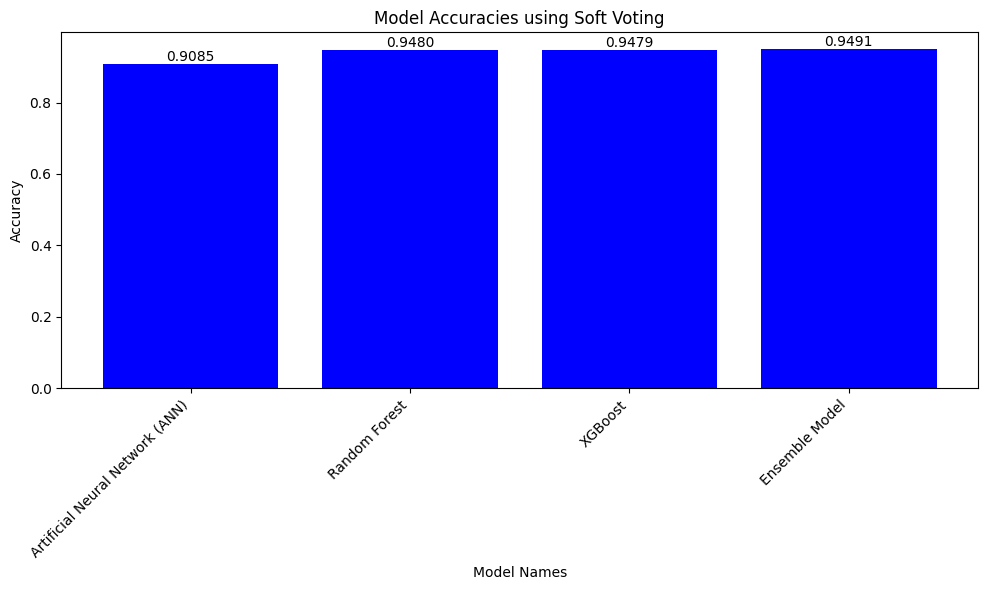

In [27]:
'''import matplotlib.pyplot as plt

# Sample data - replace this with your actual data
model_names = ['Artificial Neural Network (ANN)', 'Random Forest', 'XGBoost', 'Ensemble Model']
accuracies = [nn_accuracy_test, rf_accuracy_test, xgb_accuracy_test, ensemble_accuracy_test]

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='blue')

# Add labels and title
plt.xlabel('Model Names')
plt.ylabel('Accuracy')
plt.title('Model Accuracies using Soft Voting')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{accuracy:.4f}', ha='center', va='bottom')
    
# Display the plot
plt.tight_layout()
plt.savefig('model_accuracies_SoftVoting.jpeg')
plt.show()

'''

In [24]:
nn_accuracy_train = accuracy_score(y_train, nn_predictions_train)
nn_accuracy_test = accuracy_score(y_test, nn_predictions_test)

#print("Neural Network Model Train Accuracy:", nn_accuracy_train)
print("Neural Network Model Test Accuracy:", nn_accuracy_test)

xgb_accuracy_train = accuracy_score(y_train, xgb_predictions_train)
xgb_accuracy_test = accuracy_score(y_test, xgb_predictions_test)

#print("XGBoost Model Train Accuracy:", xgb_accuracy_train)
print("\nXGBoost Model Test Accuracy:", xgb_accuracy_test)

rf_accuracy_train = accuracy_score(y_train, rf_predictions_train)
rf_accuracy_test = accuracy_score(y_test, rf_predictions_test)

#print("Random Forest Model Train Accuracy:", rf_accuracy_train)
print("\nRandom Forest Model Test Accuracy:", rf_accuracy_test)

Neural Network Model Test Accuracy: 0.9084785680640602

XGBoost Model Test Accuracy: 0.9478568064060292

Random Forest Model Test Accuracy: 0.9479510127178521


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, nn_predictions_test, average='weighted')
recall = recall_score(y_test, nn_predictions_test, average='weighted')
f1 = f1_score(y_test, nn_predictions_test, average='weighted')

print("Neural Network Model - ")
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

##############

precision = precision_score(y_test, xgb_predictions_test, average='weighted')
recall = recall_score(y_test, xgb_predictions_test, average='weighted')
f1 = f1_score(y_test, xgb_predictions_test, average='weighted')

print("XGBoost Model - ")
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

################

precision = precision_score(y_test, rf_predictions_test, average='weighted')
recall = recall_score(y_test, rf_predictions_test, average='weighted')
f1 = f1_score(y_test, rf_predictions_test, average='weighted')

print("Random Forest Model - ")
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

#################

precision = precision_score(y_test, ensemble_predictions_test, average='weighted')
recall = recall_score(y_test, ensemble_predictions_test, average='weighted')
f1 = f1_score(y_test, ensemble_predictions_test, average='weighted')

print("Ensemble Model - ")
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Neural Network Model - 
Precision: 0.9065700162144273
Recall: 0.9084785680640602
F1-score: 0.9072491466853377
XGBoost Model - 
Precision: 0.9472032096355149
Recall: 0.9478568064060292
F1-score: 0.9466263792178711
Random Forest Model - 
Precision: 0.947337776682757
Recall: 0.9479510127178521
F1-score: 0.9466821210634048
Ensemble Model - 
Precision: 0.9479059354216699
Recall: 0.9483749411210551
F1-score: 0.9470017481951121


In [19]:
report = classification_report(y_test, nn_predictions_test)

# Print the classification report
print("Classification Report for Neural Network Model:")
print(report)


Classification Report for Neural Network Model:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     16762
           1       0.80      0.75      0.77      4468

    accuracy                           0.91     21230
   macro avg       0.87      0.85      0.86     21230
weighted avg       0.91      0.91      0.91     21230



In [22]:
report = classification_report(y_test, xgb_predictions_test)

# Print the classification report
print("Classification Report for XGBoost Model:")
print(report)


Classification Report for XGBoost Model:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     16762
           1       0.93      0.82      0.87      4468

    accuracy                           0.95     21230
   macro avg       0.94      0.90      0.92     21230
weighted avg       0.95      0.95      0.95     21230



In [21]:
report = classification_report(y_test, rf_predictions_test)

# Print the classification report
print("Classification Report for Random Forest Model:")
print(report)


Classification Report for Random Forest Model:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     16762
           1       0.93      0.82      0.87      4468

    accuracy                           0.95     21230
   macro avg       0.94      0.90      0.92     21230
weighted avg       0.95      0.95      0.95     21230



In [18]:
report = classification_report(y_test, ensemble_predictions_test)

# Print the classification report
print("Classification Report for Ensemble Model:")
print(report)


Classification Report for Ensemble Model:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     16762
           1       0.93      0.81      0.87      4468

    accuracy                           0.95     21230
   macro avg       0.94      0.90      0.92     21230
weighted avg       0.95      0.95      0.95     21230



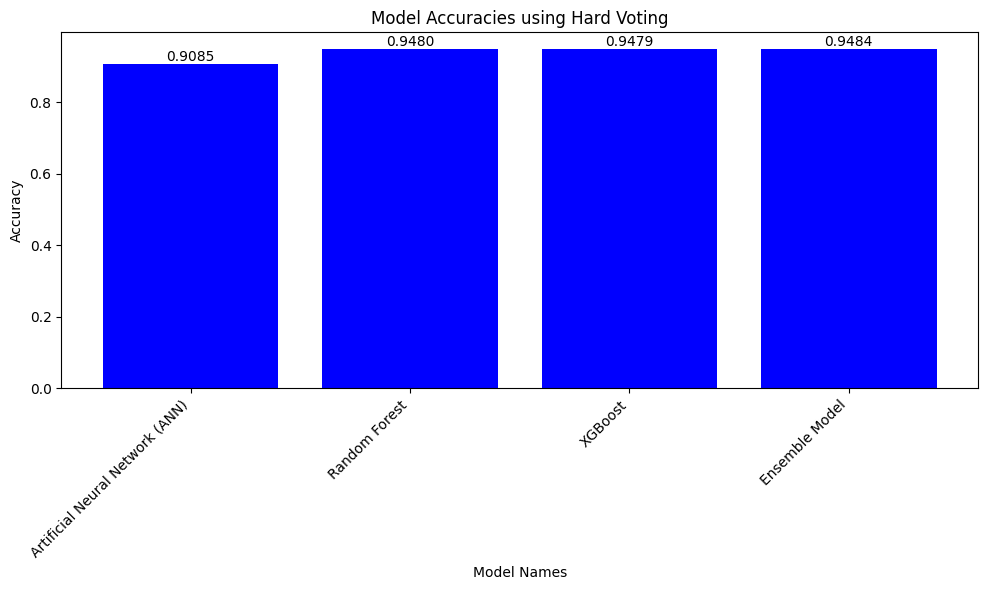

In [13]:
import matplotlib.pyplot as plt

# Sample data - replace this with your actual data
model_names = ['Artificial Neural Network (ANN)', 'Random Forest', 'XGBoost', 'Ensemble Model']
accuracies = [nn_accuracy_test, rf_accuracy_test, xgb_accuracy_test, ensemble_accuracy_test]

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color='blue')

# Add labels and title
plt.xlabel('Model Names')
plt.ylabel('Accuracy')
plt.title('Model Accuracies using Hard Voting')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{accuracy:.4f}', ha='center', va='bottom')
    
# Display the plot
plt.tight_layout()
plt.savefig('model_accuracies_temp.jpeg')
plt.show()



In [14]:
new_data = pd.DataFrame({'Comfortable_speaking_about_A_or_D': [3],
                         'Friends_Family_A_or_D': [1],
                         'A_or_D_more_than_once': [1],
                         'MH9A': [3],
                         'MH9B': [3],
                         'MH9C': [3],
                         'MH9D': [3],
                         'MH9E': [3],
                         'MH9F': [3],
                         'MH9G': [3],
                         'MH9H': [3],
                         'Age': [19],
                         'age_var2': [1],
                         'Gender': [2],
                         'Household_Income': [1],
                         'Subjective_Income': [4],
                         'EMP_2010': [4]})

new_data_tensor = torch.tensor(new_data.values, dtype=torch.float32)
new_data_scaled = scaler.transform(new_data_tensor.numpy())
new_data_scaled_tensor = torch.tensor(new_data_scaled, dtype=torch.float32)

nn_classifier.model.eval()
with torch.no_grad():
    # Forward pass
    nn_outputs = nn_classifier.model(new_data_scaled_tensor)
    # Apply softmax to get probabilities
    nn_probabilities = F.softmax(nn_outputs, dim=1)
    # Get the predicted class
    _, nn_predicted_class = torch.max(nn_probabilities, 1)

xgb_predictions_new_data = model_xgb.predict(new_data)
rf_predictions_new_data = model_rf.predict(new_data)

ensemble_predictions_new_data = []
for nn_pred, xgb_pred, rf_pred in zip(nn_predicted_class.numpy(), xgb_predictions_new_data, rf_predictions_new_data):
    ensemble_predictions_new_data.append(np.argmax(np.bincount([nn_pred, xgb_pred, rf_pred])))

# Now ensemble_predictions_new_data contains the predicted labels for the new data
print("Predicted labels for new data:", ensemble_predictions_new_data)




Predicted labels for new data: [1]


c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [15]:
new_data2 = pd.DataFrame({'Comfortable_speaking_about_A_or_D': [1],
                         'Friends_Family_A_or_D': [1],
                         'A_or_D_more_than_once': [1],
                         'MH9A': [1],
                         'MH9B': [1],
                         'MH9C': [1],
                         'MH9D': [3],
                         'MH9E': [1],
                         'MH9F': [2],
                         'MH9G': [3],
                         'MH9H': [2],
                         'Age': [42],
                         'age_var2': [2],
                         'Gender': [1],
                         'Household_Income': [5],
                         'Subjective_Income': [2],
                         'EMP_2010': [1]})

new_data_tensor2 = torch.tensor(new_data2.values, dtype=torch.float32)
new_data_scaled2 = scaler.transform(new_data_tensor2.numpy())
new_data_scaled_tensor2 = torch.tensor(new_data_scaled2, dtype=torch.float32)

nn_classifier.model.eval()
with torch.no_grad():
    # Forward pass
    nn_outputs = nn_classifier.model(new_data_scaled_tensor2)
    # Apply softmax to get probabilities
    nn_probabilities = F.softmax(nn_outputs, dim=1)
    # Get the predicted class
    _, nn_predicted_class = torch.max(nn_probabilities, 1)

xgb_predictions_new_data = model_xgb.predict(new_data2)
rf_predictions_new_data = model_rf.predict(new_data2)

ensemble_predictions_new_data = []
for nn_pred, xgb_pred, rf_pred in zip(nn_predicted_class.numpy(), xgb_predictions_new_data, rf_predictions_new_data):
    ensemble_predictions_new_data.append(np.argmax(np.bincount([nn_pred, xgb_pred, rf_pred])))

# Now ensemble_predictions_new_data contains the predicted labels for the new data
print("Predicted labels for new data:", ensemble_predictions_new_data)

Predicted labels for new data: [1]


c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\prana\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
